# Expérience basique
## Analyser le comportement de sysbench oltp pour différentes taille mémoire
### Description
Le but de cette expérience est d'analyser et comprendre le comportement du benchmark `sysbench oltp`.

Ce benchmark a pour but de modéliser le comportement d'une application de traitement de transaction en ligne (comme un site de vente de biens par exemple).

Ainsi, ce benchmark sera exécuté avec différentes limites mémoire afin de voir si celle-ci a un impact sur les performances du benchmark. Le benchmark sera executé 300 secondes dans sa version en lecture seule avec une base de données composée d'une table comportant chacune 5000000 enregistement (soit une base de données d'environ 1GB).

#### Environnement
Le benchmark sera exécuté dans un conteneur qui le contiendra ainsi que le système de gestion de base de données `mysql` avec lequel il interragira.

Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 3GB de mémoire et 2 coeurs. La bande passante disque en lecture a été limitée à 5MB/s.

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

Les différentes exécutions n'ont pas d'impact les unes sur les autres car le cache fichier est vidé entre chaque itération.

#### Résultats attendus
Nous pouvons nous attendre à une baisse des performances (c'est-à-dire une augmentation de la latence des requêtes) lorsque la limite mémoire diminue.

#### Algorithme de l'expérience
Les expériences ont été répétées 10 fois afin de calculer une moyenne et l'écart-type associé.

La limite mémoire ne sera activée qu'une fois que la phase de prépration du benchmark sera terminée (c'est-à-dire une fois que la base de donnée aura été créée).

Le script permettant de lancer le conteneur temps et d'obtenir des statistiques sur celio-ci est le suivant :
```python
#! /usr/bin/env python3
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>
import sys
import docker
import os
import json
import time

"""This python script will start a container with sysbench with the given as
argument memory limit.

It will then run 10 times the wml_file given as argument. The output of
filebench will be written to a file and statistics (memory usage in bytes and
reads from the disk) will be written to another file.
"""

# sysbench last 300 seconds.
DURATION = 300

# The preparation command for sysbench oltp. The database is around 1GB big.
PREPARATION = 'sysbench /usr/share/sysbench/oltp_read_only.lua --table_size=5000000 prepare'

# The run command of sysbench oltp.
RUN = 'sysbench --time=%d /usr/share/sysbench/oltp_read_only.lua --table_size=5000000 run' % DURATION

# The keys added to a temporary dictionary.
KEYS = ['Usage', 'Read']

def main():
	if len(sys.argv) != 2:
		sys.exit("Usage: %s memory_limit" % sys.argv[0])

	client = docker.from_env()

	# Launch container as detached. Its limit will be set once the preparation is
	# done.
	container = client.containers.run('sysbench', auto_remove = True, detach = True)

	# Open /proc/sys/vm/drop_caches to be able to drop linux page cache.
	drop_cache = open('/proc/sys/vm/drop_caches', 'wb', buffering = 0)

	# Wait 30 seconds so the sysbench container is ready. Indeed, it can be slow
	# because mysql is long to boot.
	time.sleep(30)

	# Prepare the files
	container.exec_run(PREPARATION)

	# Set the memory limit to given argument. We also need to set the swap limit
	# otherwise there will be exception raised. But since there is no swap on the
	# VM I do not think it is a problem.
	container.update(mem_limit = sys.argv[1], memswap_limit = sys.argv[1])

	# Drop the cache so the preparation above does not have a consequence on the
	# runs below.
	drop_cache.write(bytearray('3\n', 'utf-8'))

	out = open(os.path.expanduser('~/sysbench_oltp_%s.out' % sys.argv[1]), 'w')

	stats = open(os.path.expanduser('~/sysbench_oltp_%s.stats' % sys.argv[1]), 'w')

	stats.write('iteration;usage;reads\n')

	# Run the sysbench 10 times to compute mean and standard deviation.
	for i in range(10):
		gen = container.stats()

		# Run the benchmark inside the container and write the output to out.
		# exec_run returns a tuple whom second field contains bytes. The decode
		# translate them to a string.
		out.write(container.exec_run(RUN)[1].decode('utf-8') + '\n')

		statistics = []
		old_values = {'Read': 0, 'Write': 0}

		for record in gen:
			# Translate the record in string and translate it to python dictionary.
			# Vive la Joz' ! Bon vivant docteur bon vivant !
			jason = json.loads(record.decode('utf-8'))

			# Create a new dictionary at each iteration so the statistics's cases are
			# differents.
			chicandier = {'Usage': jason['memory_stats']['usage']}

			for io in jason['blkio_stats']['io_serviced_recursive']:
				if io['op'] == 'Read':
					# Get the difference between this iteration and the previous one.
					# The value is the number of read or write for this second. It can be
					# seen as the bandwith.
					val = io['value'] - old_values[io['op']]

					# Update the old value. Since it begins at 0 the first value will be
					# quite wrong but I do not think it will be a big problem.
					old_values[io['op']] = io['value']

					# Little trick if the key is not already present.
					# TODO Maybe this if is useless since this code is called each second
					# and chicandier is recreate each second. But it works and I will no
					# loose some time for a little if...
					if io['op'] in chicandier:
						chicandier[io['op']] += val
					else:
						chicandier[io['op']] = val

			statistics.append(chicandier)

			# Our sysbench last 60 seconds so we just want 60 records since
			# containerd give stats every second.
			if len(statistics) == DURATION:
				break

		# Add the statistics to the stat file.
		for i in range(len(statistics)):
			stats.write('%d' % i)

			# Write each statistics in order.
			for key in KEYS:
				stats.write(';%d' % statistics[i][key])

			stats.write('\n')

		# Drop the cache between each run so they are independents.
		drop_cache.write(bytearray('3\n', 'utf-8'))

	# Stop and close everything.
	container.stop()

	out.close()

	stats.close()

	drop_cache.close()

if __name__ == "__main__":
    main()
```

Ces scripts ont ensuite été exécutés depuis un script bash qui gère les différentes configuration de limite mémoire :
```bash
#! /usr/bin/env bash
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>

for i in 3000M 2000M 1500M 1000M 500M 400M 300M 250M; do
	python3 baseline_oltp.py $i
	echo "Finished run oltp for $i!"
done
```

#### Résultats obtenus
Pour chaque limite mémoire, les performances sont obtenues en mesurant la latence des requêtes.
Pendant l'exécution des conteneurs, leurs empreintes mémoires (en octet) ainsi que leurs nombres de lectures et d'écritures effectuées depuis le disque ont été collectées chaque seconde. Des moyennes et leurs écarts-types associés ont été calculés pour chaque seconde.

**Le point 0 est parfois omis car son écart-type présente des valeurs étranges pour des raisons techniques un peu complexes mais qui n'ont pas d'impact sur les expériences.**

##### Nombre de requêtes et latence de celles-ci
Les histogrammes suivant dépeignent le nombre de requêtes effectuées et la latence de celle-ci en fonction de différentes limites mémoires :

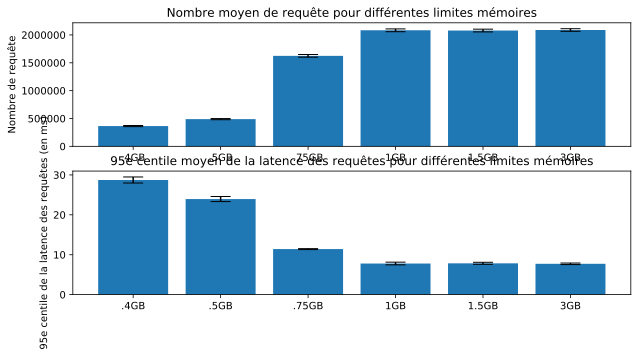

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

DIR = 'results'
FILES = ['%s/sysbench_oltp_400M.out.csv' % DIR, '%s/sysbench_oltp_500M.out.csv' % DIR, '%s/sysbench_oltp_750M.out.csv' % DIR, '%s/sysbench_oltp_1000M.out.csv' % DIR, '%s/sysbench_oltp_1500M.out.csv' % DIR, '%s/sysbench_oltp_3000M.out.csv' % DIR]

queries_means = []
queries_stds = []

latency_means = []
latency_stds = []

for file in FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    queries_means.append(values.mean(0)[1])
    queries_stds.append(values.std(0)[1])
    
    latency_means.append(values.mean(0)[2])
    latency_stds.append(values.std(0)[2])
    
# xtick labels for the bar chart.
names = ['.4GB', '.5GB', '.75GB', '1GB', '1.5GB', '3GB']
x_pos = np.arange(len(names))

# Axis and figure initialization. There are one plot for number of queries and the other
# for latency.
fig, (queries_ax, latency_ax) = plt.subplots(nrows = 2, figsize = (10, 5))
queries_ax.bar(x_pos, queries_means, yerr = queries_stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
queries_ax.set_ylabel('Nombre de requête')
queries_ax.set_xticks(x_pos)
queries_ax.set_xticklabels(names)
queries_ax.set_title("Nombre moyen de requête pour différentes limites mémoires")

latency_ax.bar(x_pos, latency_means, yerr = latency_stds, align = 'center', capsize = 10)
# Shift the position the second bar by width.
latency_ax.set_ylabel('95e centile de la latence des requêtes (en ms)')
latency_ax.set_xticks(x_pos)
latency_ax.set_xticklabels(names)
latency_ax.set_title("95e centile moyen de la latence des requêtes pour différentes limites mémoires")

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Les écarts-types sont acceptables.

Le nombre de requête est clairement plus bas quand le benchmark s'exécute avec 400MB et 500MB et un peu plus faible avec 750M.

Identiquement la latence des configurations laisées en mémoire est élevée contrairement à celles qui disposent de beaucoup de mémoire (30ms au pire contre environ 10ms).

##### Empreinte mémoire, lecture et écriture
Afin de comprendre la différence de performance entre les deux groupes de limite mémoire intéressons nous désormais à l'usage mémoire du benchmark ainsi qu'aux écritures et lectures qu'il effectue :

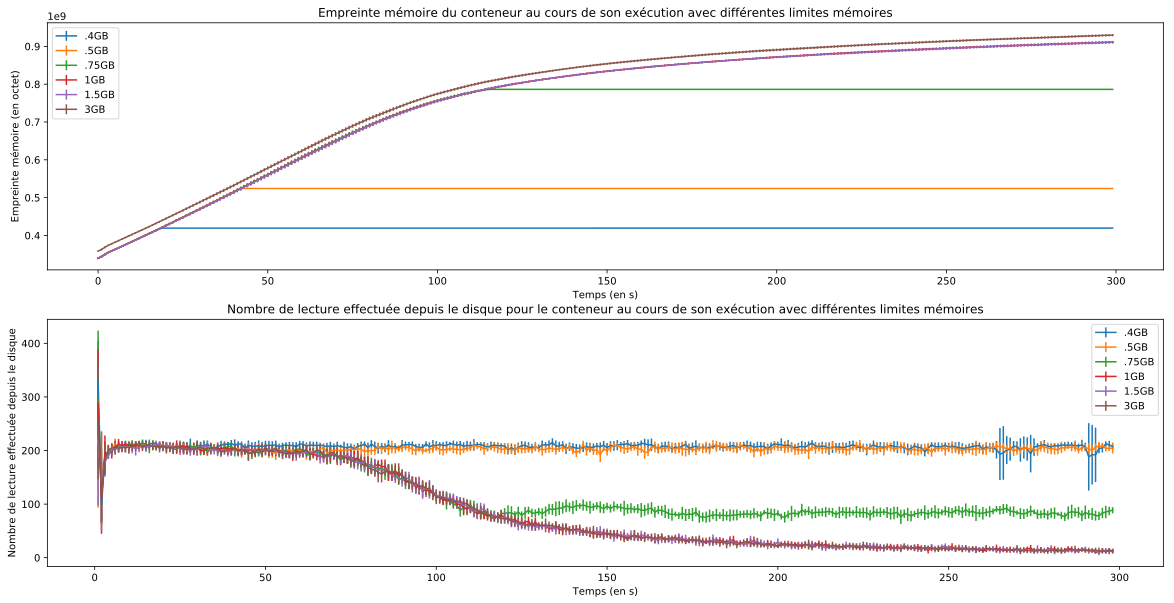

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

LABELS = ['.4GB', '.5GB', '.75GB', '1GB', '1.5GB', '3GB']

DIR = 'results'
FILES = ['%s/sysbench_oltp_400M.stats.csv' % DIR, '%s/sysbench_oltp_500M.stats.csv' % DIR, '%s/sysbench_oltp_750M.stats.csv' % DIR, '%s/sysbench_oltp_1000M.stats.csv' % DIR, '%s/sysbench_oltp_1500M.stats.csv' % DIR, '%s/sysbench_oltp_3000M.stats.csv' % DIR]

usage_means = []
usage_stds = []

reads_means = []
reads_stds = []

# xtick labels for the bar chart.
x_pos = np.arange(len(range(300)))

for file in FILES:
    df = pd.read_csv(file, ';')
    values = df.values
    
    usage_means.append(values.take(1, axis = 1))
    usage_stds.append(values.take(2, axis = 1))
    
    # The first record has strange standard deviation values so we do not get it.
    reads_means.append(values.take(3, axis = 1)[1 : len(x_pos) - 1])
    reads_stds.append(values.take(4, axis = 1)[1 : len(x_pos) - 1])

# Axis and figure initialization.
# We need three axis: one for memory usage, an other for reads from disk and the last for
# writes to disk.
fig, (usage_ax, reads_ax) = plt.subplots(nrows = 2, figsize = (20, 10))

for i in range(len(LABELS)):
    usage_ax.errorbar(x_pos, usage_means[i], yerr = usage_stds[i], label = LABELS[i])
    reads_ax.errorbar(x_pos[1 : len(x_pos) - 1], reads_means[i], yerr = reads_stds[i], label = LABELS[i])
    
usage_ax.legend()
usage_ax.set_ylabel('Empreinte mémoire (en octet)')
usage_ax.set_xlabel('Temps (en s)')
usage_ax.set_title('Empreinte mémoire du conteneur au cours de son exécution avec différentes limites mémoires')
    
reads_ax.legend()
reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
reads_ax.set_xlabel('Temps (en s)')
reads_ax.set_title('Nombre de lecture effectuée depuis le disque pour le conteneur au cours de son exécution avec différentes limites mémoires')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

L'empreinte mémoire du conteneur tend vers 1GB pour les hautes limites mémoires. Tandis que l'empreinte mémoire est limitée à 400MB et 500MB puis 750MB pour les limites mémoires 400MB, 500MB et 750MB.

Cette empreinte mémoire limitée implique donc un nombre de lecture constant d'environ 200 lectures par seconde pour 400MB et 500MB. Pour 750MB le nombre de lecture diminue jusqu'à arriver à la valeur de 100 lectures par seconde.
Ce nombre tend vers 0 pour les hautes limites mémoires.

### Conclusion
Lorsque la base de donnée manipulée par le benchmark ne tient pas en mémoire celui-ci effectue moins de requêtes pour un temps donné. La latence est aussi dégradée..

Il faut néanmoins attendre au moins une minute pour que les limites aient un impact sur les performances du benchmark.